<a href="https://colab.research.google.com/github/ale-camer/Finance/blob/master/Stock_Algorithmic_Trading_Strategy_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Summary

OBJECTIVE
> Compare various stock price transformation methods in order to segment them in various ways and calculate the return of a buy-and-hold investment strategy of a chosen segment periodically for the purposes of its theoretical use as an algorithmic mutual fund. In this regard we transform, segment and select stocks with one year past data every quarter for a six year period.

> This project is within the framework of the Quantitative Finance Executi Program (QUANt) of the CEMA University from Argentina. Therefore, the prints of each chunk of code are spanish but nevertheless all comments and results explanations are in english for the convenience of the broad audience. 


Data types:

    - Opening price
    - Close price
    - Maximum price
    - Minimum price
    - Adjusted close price

Types of segmentation:

    - Dynamic: statistics of time windows within a period.
        - K-means clustering of statistics correlation matrix (nClusters = 10)
        - K-means clustering of statistics covariance matrix (nClusters = 10)
        - K-means clustering of statistics matrix (nClusters = 10)
    - Static: whole period statistics.
        - Statistics deciles (equiprobable)
        - Same distance (equidistant)
    
Statistics to segment:

    - Return = (p1 / p0 - 1).mean() 
    - Risk = (p1 / p0 - 1).std()
    - Bias = ((Xi - X.mean())^3).sum() / ((N - 1) * X.std()^3)
    - Kurtosis = ((Xi - X.mean())^4).sum() / (N * X.std()^4)
    - Betas = pendiente de regresión lineal simple en donde x: mercado e y: acción
    - Sharpe Ratio = rendimiento acción / riesgo acción
    - Information Ratio = (rendimiento acción - rendimiento mercado) / (rendimiento acción - rendimiento mercado).std()
    - Burke Ratio = rendimiento acción / (p1 / p0 - 1 <=> < 0)**2.sum().sqrt()
    - Treynor Ratio = rendimiento acción / beta
    - Sortino Ratio = rendimiento acción / (p1 / p0 - 1 <=> < 0).std()
    - Calmar Ratio = rendimiento acción / (p1 / p0 - 1).min()

Segment selection methods:

    - Lower bound: minimum proportion of stocks, over all of them, to be considered within the segment.
    - Upper bound: maximum proportion of stocks, over all of them, to be considered within the segment.
    - Min: select the first segment sorting them in ascending order. Which means that the stock of the segment whose average statistic is the one with the lowest value is selected to invest in.
    - Max: select the first segment sorting them in descending order. Which means that the stock of the segment whose average statistic is the one with the highest value is selected to invest in.




## Classes and Functions


In [ ]:
# download of S&P500 tickers price data 
class snp500data():
    
    """
    The objective of this class is to download the prices of the stocks listed in the S&P500 index and store it in an Excel file if wanted.
    """
    
    def __init__(self,time:int):
        
        import datetime as dt
        
        assert type(time) == int, "The variable 'time' must be an integer. Therefore, avoid the dot when writing the input. For example, if you want the stocks prices since six years ago, instead of writing 6.0 you must write 6."
    
        self.typesData = ['Open', 'Close', 'Low', 'High', 'Adj Close'] # type of prices
        self.years = time # years to go back in time
        self.since = dt.datetime.now() - dt.timedelta(days = 365 * self.years) # date format for the integer representing the years since price are downloaded
        self.until = dt.datetime.now()
        
        self.tickers = 1
        self.stockData = 1
        self.stockData_ = 1
        
    def Download_SnP500_Data(self):
        
        """
        This function download the data and store it in a variable. Therefore, an integer representing years 
        must be set as an input in order to download prices since then.        
        """
        
        from tqdm import tqdm
        import yfinance as yf
        import pandas as pd
        
        toReplace = {'BRK.B':'BRK-B','BF.B':'BF-B'}
        self.tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') # download S&P500 tickers
        self.tickers = self.tickers[0]['Symbol']
        self.tickers.replace(toReplace,inplace=True) # replace incompatible tickers
        self.tickers = self.tickers.unique()
        
        # downloading data in a dictionary of pandas dataframes
        self.stockData = {} # create first empty dictionary
        for tick in tqdm(self.tickers): # iterate over S&P500 company tickers
            self.stockData[f"{tick}"] = yf.download(tick, start = self.since, end = self.until, progress = False) # downloading data

        self.stockData_ = {} # create second empty dictionary
        for typeData in self.typesData: # iterate over all types of stock prices
          self.stockData_[typeData] = pd.DataFrame() # create empty pandas dataframes in each element of the second dictionary
        for typeData in self.typesData: # iterate over all types of stock prices
            for tick in self.tickers: # iterate over S&P500 company tickers
                self.stockData_[typeData][tick] = self.stockData[tick][typeData] # store in dataframes within the second dictionary all stocks price every type of stock prices
                
        return self.stockData_
    
    def Save_SnP500_Data(self,route:str):
        
        """
        This function store the data in an Excel file. Therefore, a directory in which you want to store the Excel file must be
        set as an input.
        
        In the Excel file, with the name snp500tickersData.xlsx,you will find in each sheet each type of price: Open, Close, High, Low and Adj. Close.
        """
        
        from pandas import ExcelWriter
        
        assert type(route) == str, "The 'route' variable must be a string"
        
        self.route = route # directory where the data is store
        
        writer = ExcelWriter(self.route+'snp500tickersData.xlsx') # save data in an Excel file
        for key in list(self.stockData_.keys()): # iterate over the second dictionary
                self.stockData_[key].to_excel(writer, key, engine='xlsxwriter') # print data in an Excel file in different sheets according to the types of stock prices 
        return writer.save()
        
# download of S&P500 index price data
class snp500index():
    
    """
    The objective of this class is to download the prices of the S&P500 index and store it in an Excel file if wanted.
    """
    
    def __init__(self,time:int):
        
        import datetime as dt
        
        assert type(time) == int, "The variable 'time' must be an integer. Therefore, avoid the dot when writing the input. For example, if you want the index prices since six years ago, instead of writing 6.0 you must write 6."
    
        self.years = time # years to go back in time
        self.since = dt.datetime.now() - dt.timedelta(days = 365 * self.years) # date format for the integer representing the years since price are downloaded
        self.until = dt.datetime.now()
        
    def Download_SnP500_Index(self):
        
        """
        This function download the data and store it in a variable. Therefore, an integer representing years 
        must be set as an input in order to download prices since then.
        """
        
        import yfinance as yf
        
        self.snp500index = yf.download('^GSPC', start = self.since, end = self.until, progress = False)['Close'] # downlaod S&P500 index data
        
        return self.snp500index
    
    def Save_SnP500_Index(self,route:str):
        
        """
        This function let you store the data in an Excel file. Therefore, the directory in which you want 
        to store the Excel file must be set as an input.
        
        In the Excel file, with the name snp500indexData.xlsx,you will find only one sheet with the close prices.
        """
        
        assert type(route) == str, "The 'route' variable must be a string"
                
        self.route = route # directory where the data is store
        return self.snp500index.to_excel(route+"snp500indexData.xlsx") # printing the Excel file

# data transformation
class Data_Transformation:
    
    """
    The objective of this class is to transfrom the data in different ways.
    
    First of all, the data use it as an input must be a Pandas DataFrame with the dates in the index and the stocks in the columns.
    
    The types of transformations that can be done in this class are two: dynamic or static. By dynamic we mean that the statistics 
    are calculated on a window time period and therefore the output is another Pandas DataFrame. In case of static transformations, the
    statistics are calculated for the whole period considered and therefore the output is a Pandas Series.
    
    The transformations that this functions perform are:
        
        - Returns (Mean or First Moment)
        - Risk (Variance or Second Moment)
        - Skewness (Third Moment)
        - Kurtosis (Forth Moment)
        - Sharpe Ratio
        - Information Ratio
        - Burke Ratio
        - Treynor Ratio
        - Sortino Ratio
        - Calmar Ratio
        - Betas (Slope)
        
    This must be specified in the 'trans_type' input by the following names: 'retorno', 'riesgo', 'sesgo', 'curtosis', 'sharpe_ratio',
    'information_ratio', 'burke_ratio', 'treynor_ratio', 'sortino_ratio', 'calmar_ratio' or 'beta' respectively.
    
    For the Betas, Information Ratio and Treynor Ratio the index data must be supplied. Therefore, there is a second input named 'snpData'
    which must be a Pandas Series.
    
    For dymanic transformations is important to specify the window period to consider. By default it will be 2.
    """
    
    def __init__(self, df):
        
        import pandas as pd
        
        assert type(df) == pd.DataFrame, "The variable 'df' must be a Pandas DataFrame" 
        
        self.df = df
        
    def Dynamic_Transformation(self,snpData,trans_type:str,window:int=2):
        
        """
        The objective of this function is to perform dynamic transformations with a two time peiod window in order to output a matrix with the desired transformation
        performed in the input data.
        """
        
        import numpy as np
        import pandas as pd
        from scipy.stats import skew, kurtosis
        import warnings
        warnings.filterwarnings("ignore")
        
        assert type(snpData) == pd.Series, "The variable 'snpData' must be a Pandas Series" 
        assert type(trans_type) == str, "The variable 'trans_type' must be a string"
        
        self.trans_type = trans_type
        
        if self.trans_type == 'retorno':
            
            self.df1 = pd.DataFrame(self.df.dropna(axis=1).pct_change().rolling(window).mean().dropna(axis=0))
            
        elif self.trans_type == 'riesgo':
            
            self.df1 = pd.DataFrame(self.df.dropna(axis=1).pct_change().rolling(window).std().dropna(axis=0))
            
        elif self.trans_type == 'sesgo':
            
            skews  = []
            for i in range(len(self.df)-2):
                lis = pd.DataFrame(skew(self.df.iloc[i:i+window+1,:].dropna(axis=1).pct_change().dropna()*100*252))
                skews.append(lis)        
            skews = pd.concat(skews,axis=1).T
            skews = skews.dropna(axis=1)
            skews.index = self.df.dropna(axis=1).pct_change().dropna().index[:-1]
            skews.columns = self.df.dropna(axis=1).columns
            self.df1 = skews
            
        elif self.trans_type == 'curtosis':
            
            curts  = []
            for i in range(len(self.df)-2):
                lis = pd.DataFrame(kurtosis(self.df.iloc[i:i+window+1,:].dropna(axis=1).pct_change().dropna()*100*252))
                curts.append(lis)        
            curts = pd.concat(curts,axis=1).T
            curts = curts.dropna(axis=1)
            curts.index = self.df.dropna(axis=1).pct_change().dropna().index[:-1]
            curts.columns = self.df.dropna(axis=1).columns
            self.df1 = curts + 3
            
        elif self.trans_type == 'sharpe_ratio':
        
            self.df1 = (pd.DataFrame(self.df.dropna(axis=1).pct_change().rolling(window).mean().dropna(axis=0)) / pd.DataFrame(self.df.dropna(axis=1).pct_change().rolling(window).std().dropna(axis=0)))
  
        elif self.trans_type == 'information_ratio':
            
            ir = [] # empty list
            a, b = self.df.dropna(axis=1).pct_change().dropna(), snpData.pct_change().dropna() # taking returns from stocks and index
            for i in range(len(self.df)-1):
                ir.append(a.iloc[i,:] - b[i]) # populating list with differences between stocks and index return   
            irs = pd.concat(ir,axis=1).T # putting data into a Pandas DataFrame
            irs = irs.rolling(window).mean().dropna(axis=0) / irs.rolling(window).std().dropna(axis=0) # calculating Information Ratio
            self.df1 = irs
            
        elif self.trans_type == 'burke_ratio':
            
            a = self.df.dropna(axis=1).pct_change().dropna() # stocks returns
            self.df1 = a.rolling(window).mean().dropna(axis=0) / a[a < 0].replace(np.nan,0.01).rolling(window).sum().dropna(axis=0) # calculating Burke Ratio
            
        elif self.trans_type == 'beta':
            
            a, b = self.df.dropna(axis=1).pct_change().dropna(), snpData.pct_change().dropna() # taking returns from stocks and index
            a1 = pd.DataFrame() # empty Pandas Dataframe
            for col in a.columns:
                for row in range(len(a.index)):
                    beta = np.cov(a[col][row:row+window].values,b[row:row+window].values)[0][1] / np.var(b[row:row+window]) # calculating beta
                    a1.loc[a[col][row:].index[0], col] = beta # populating dataframe
            self.df1 =  a1.dropna() # drop missing data
            
        elif self.trans_type == 'treynor_ratio':
            
            a, b = self.df.dropna(axis=1).pct_change().dropna(), snpData.pct_change().dropna() # taking returns from stocks and index
            a1 = pd.DataFrame() # empty Pandas Dataframe
            for col in a.columns:
                for row in range(len(a.index)):
                    beta = np.cov(a[col][row:row+window].values,b[row:row+window].values)[0][1] / np.var(b[row:row+window]) # calculating beta
                    a1.loc[a[col][row:].index[0], col] = beta # populating dataframe
            a1 = a1.dropna() # drop missing data
            self.df1 = a.iloc[1:,:] / a1 # calculating Treynor Ratio
            self.df1.dropna(inplace=True)
            
        elif self.trans_type == 'sortino_ratio':
            
            a = self.df.dropna(axis=1).pct_change().dropna() # stocks returns
            self.df1 = a.rolling(window).mean().dropna(axis=0) / a[a < 0].replace(np.nan,0.01).rolling(window).std().dropna(axis=0) # calculating Sortino Ratio
            
        elif self.trans_type == 'calmar_ratio':

            a = self.df.dropna(axis=1).pct_change().dropna() # stocks returns
            self.df1 = a.rolling(window).mean().dropna(axis=0) / a[a < 0].replace(np.nan,0.01).rolling(window).min().dropna(axis=0) # calculating Calmar Ratio
    
        else: pass
    
        return self.df1
    
    def Static_Transformation(self,snpData,trans_type:str):
        
        """
        The objective of this function is to perform static transformations within a time period in order to output a serie with the desired transformation
        performed in the input data.
        """
        
        import pandas as pd
        import numpy as np
        from scipy.stats import skew, kurtosis
        import warnings
        warnings.filterwarnings("ignore")

        assert type(snpData) == pd.Series, "The variable 'snpData' must be a Pandas Series" 
        assert type(trans_type) == str, "The variable 'trans_type' must be a string"

        self.trans_type = trans_type
        
        if self.trans_type == 'retorno':
            
            self.df1 = pd.DataFrame((1 + self.df.dropna(axis=1).pct_change().mean())**252 - 1).rename(columns={0:'value'})

        elif self.trans_type == 'riesgo':

            self.df1 = pd.DataFrame(self.df.dropna(axis=1).pct_change().std() * 252**0.5).rename(columns={0:'value'})

        elif self.trans_type == 'sesgo':

            self.df1 = pd.DataFrame(skew(self.df.dropna(axis=1).pct_change().dropna())).rename(columns={0:'value'})
            self.df1.index = self.df.dropna(axis=1).pct_change().dropna().columns

        elif self.trans_type == 'curtosis':

            self.df1 = pd.DataFrame(kurtosis(self.df.dropna(axis=1).pct_change().dropna())+3).rename(columns={0:'value'})
            self.df1.index = self.df.dropna(axis=1).pct_change().dropna().columns

        elif self.trans_type == 'sharpe_ratio':
        
            self.df1 = pd.DataFrame((1 + self.df.dropna(axis=1).pct_change().mean())**252 - 1) / pd.DataFrame(self.df.dropna(axis=1).pct_change().std() * 252**0.5)
            self.df1.index = self.df.dropna(axis=1).columns
            self.df1.columns = ['value']

        elif self.trans_type == 'information_ratio':
            
            self.df.dropna(axis=1,inplace=True)
            self.df1 = pd.DataFrame(
                (self.df.pct_change().dropna().mean() * 252 - (snpData.pct_change().dropna().mean() * 252)).values / \
                    pd.DataFrame(self.df.pct_change().dropna().mean() * 252 - (snpData.pct_change().dropna().mean() * 252)).std().values).rename(columns = {0 : 'value'}) 
            self.df1.index = self.df.columns
            
        elif self.trans_type == 'burke_ratio':
            
            self.df.dropna(axis=1,inplace=True)
            self.df1 = pd.DataFrame(
                (self.df.pct_change().dropna().mean() * 252) / \
                    pd.DataFrame(self.df.pct_change()[self.df.pct_change() < 0]**2).sum()**0.5).rename(columns = {0 : 'value'})
                    
        elif self.trans_type == 'beta':
            
            self.df.dropna(axis=1,inplace=True)
            self.df1 = []
            for col in self.df.columns:
                beta = np.cov(self.df[col].values,snpData.values.ravel())[0][1] / np.var(snpData)
                self.df1.append((col,beta))
            self.df1 = pd.DataFrame(self.df1).set_index(0).rename(columns = {1 : 'value'})
            
        elif self.trans_type == 'treynor_ratio':
            
            self.df.dropna(axis=1,inplace=True)
            rtos = pd.DataFrame(self.df.pct_change().dropna().mean() * 252)
            betas = []
            for col in self.df.columns:
                beta = np.cov(self.df[col].values,snpData.values.ravel())[0][1] / np.var(snpData)
                betas.append((col,beta))
            betas = pd.DataFrame(betas).set_index(0)
            self.df1 = pd.DataFrame(rtos.values/betas.values).rename(columns = {0 : 'value'})
            self.df1.index = self.df.columns
            
        elif self.trans_type == 'sortino_ratio':
            
            self.df.dropna(axis=1,inplace=True)
            rtos = pd.DataFrame(self.df.pct_change().dropna().mean() * 252)
            stds = self.df.pct_change()[self.df.pct_change() < 0].std()
            self.df1 = pd.DataFrame(rtos.values.ravel() / stds.values).rename(columns = {0 : 'value'})
            self.df1.index = self.df.columns
            
        elif self.trans_type == 'calmar_ratio':
            
            self.df.dropna(axis=1,inplace=True)
            rtos = pd.DataFrame(self.df.pct_change().dropna().mean() * 252)
            minimos = pd.DataFrame(self.df.pct_change().dropna().min())
            self.df1 = pd.DataFrame(rtos.values / minimos.values).rename(columns = {0 : 'value'})
            self.df1.index = self.df.columns
            
        else: pass        

        return self.df1
    
# data segmentation
class segmentacion:
    
    """
    The objective of this class is to segment data. This can be done here in three different ways: by clustering 
    matrices (correlation, covariance or pure data) with the kMeans algorith or by grouping equidistant or equiprobable
    statistics in a vector.    
    
    Therefore, the input of this class must be either a Pandas DataFrame or a Pandas Series.
    """
    
    def __init__(self,df):

        import pandas as pd
        import numpy as np

        assert type(df) == pd.DataFrame or type(df) == pd.Series, "The variable 'df' must be a either a Pandas DataFrame or a Pandas Series"        

        self.df = df
        indexDelete = self.df.isna().sum()[(self.df.isna().sum() > 5) | (np.isinf(self.df).sum() > 5)].index
        self.df = self.df.drop(indexDelete,axis=1)
        self.df = self.df.replace({np.nan:0,np.inf:0})
        
class segmentacion:
    
    """
    The objective of this class is to segment data. This can be done here in three different ways: by clustering 
    matrices (correlation, covariance or pure data) with the kMeans algorith or by grouping equidistant or equiprobable
    statistics in a vector.    
    
    Therefore, the input of this class must be either a Pandas DataFrame or a Pandas Series.
    """
    
    def __init__(self,df):

        import pandas as pd
        import numpy as np

        assert type(df) == pd.DataFrame or type(df) == pd.Series, "The variable 'df' must be a either a Pandas DataFrame or a Pandas Series"        

        self.df = df
        indexDelete = self.df.isna().sum()[(self.df.isna().sum() > 5) | (np.isinf(self.df).sum() > 5)].index
        self.df = self.df.drop(indexDelete,axis=1)
        self.df = self.df.replace({np.nan:0,-np.inf:0,+np.inf:0})
        
    def Clustering(self,matrix:str='correlacion',nClusters:int=10,min_max:str='max',limite_inferior=0.02,limite_superior=0.15):
        
        """
        This function cluster different type of matrices with the kMeans algorithm from the Scikit Learn framework.
        
        Therefore, the kind of matrix and the number of clusters must be set as inputs. In the 'matrix' input we have to
        specify the type of matrix in order to calculate it if necessary. Therefore we must choose between the categories: 'correlacion', 
        'covarianza' or 'normal', in order to calculate the correlation or covariance matrix or use raw data respectively.
        
        In order to set the number of clusters we only have to set an integer in the 'nClusters' input.
        """
            
        import numpy as np
        import pandas as pd
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import MinMaxScaler

        self.matrix = matrix
        self.nClusters = nClusters
        
        scaler = MinMaxScaler() # initializing scaler
        
        if self.matrix == 'correlacion':
            
            self.df1 = pd.DataFrame(self.df.corr()) # producing correlation matrix
            
            if len(self.df1.isna().sum()[self.df1.isna().sum() > 1].index) >= 1:
                self.df1.drop(self.df1.isna().sum()[self.df1.isna().sum() > 1].index,axis=1,inplace=True)
                self.df1.dropna(inplace=True)
                
        elif self.matrix == 'covarianza':
            
            self.df1 = pd.DataFrame(scaler.fit_transform(self.df)).copy() # scaling data
            self.df1 = pd.DataFrame(np.cov(self.df1.T)) # producing covariance matrix
            self.df1.columns, self.df1.index = self.df.columns, self.df.columns
            
        elif self.matrix == 'normal':
            
            self.df1 = pd.DataFrame(scaler.fit_transform(self.df)).copy() # scaling data
            self.df1.columns = self.df.columns
            self.df1 = self.df1.T
        
        else: pass
        
        self.dfClust = KMeans(n_clusters = self.nClusters, random_state = 0).fit(self.df1) # clustering
        self.dfClust = pd.DataFrame(self.dfClust.labels_) # labels
        self.dfClust.index, self.clustersDict, self.corr_list = self.df1.index, {}, [] # naming cluster index with stocks and creating empty dictionary and list

        for a in self.dfClust[0].unique(): 
            stocks = self.dfClust[self.dfClust[0] == a].index 
            self.clustersDict[f'{a}'] = stocks # storing stocks of each label in the dictionary
        for b in self.dfClust[0].unique(): 
            self.corr_list.append((b, self.df1[self.df1.index.isin(self.clustersDict[f'{b}'])].T[self.clustersDict[f'{b}']].mean().mean())) # populating the list with the mean value of each cluster
            
        self.corr_list = pd.DataFrame(self.corr_list)
        self.corr_list.set_index(0, inplace = True)
        
        if min_max == 'max':
            try:
                i = 0
                while i < self.nClusters:
                    self.acciones = self.corr_list[self.corr_list != 1].sort_values(1, ascending = False).index[i] # selecting the cluster with the highest value
                    self.acciones = self.dfClust[self.dfClust[0] == self.acciones].index # selecting the stocks of the cluster with the largest value
                    i += 1
                    if (len(self.acciones) >= int(self.df.shape[1]*limite_inferior)) & (len(self.acciones) <= int(self.df.shape[1]*limite_superior)): break
                    else: pass                  
            except: self.acciones = self.dfClust[0].index
        elif min_max == 'min':
            try:
                i = 0
                while i < self.nClusters:
                    self.acciones = self.corr_list[self.corr_list != 1].sort_values(1, ascending = True).index[i] # selecting the cluster with the lowest value
                    self.acciones = self.dfClust[self.dfClust[0] == self.acciones].index # selecting the stocks of the cluster with the largest value
                    i += 1
                    if (len(self.acciones) >= int(self.df.shape[1]*limite_inferior)) & (len(self.acciones) <= int(self.df.shape[1]*limite_superior)): break
                    else: pass    
            except: self.acciones = self.dfClust[0].index
            
        return self.acciones
        
    def Equiprobable(self,column:str='value',min_max:str='max',limite_inferior=0.02,limite_superior=0.15):
        
        """
        The objective of this function is to group statistics in a vector by deciles.
        
        Therefore, the inputs need it are the name of the serie or the column of the dataframe, which by default is 'value', in 'column' and
        if we want lowest of highest values in 'min_max' by selecting 'min' or 'max', which by default is 'max', respectively.
        """
        
        import numpy as np
        
        self.column = column
        
        lista = [np.percentile(self.df, i) for i in np.arange(10, 91, 10)] # percentiles
        conditions = [(self.df[self.column] < lista[0]), 
                      (self.df[self.column] > lista[0]) & (self.df[self.column] <= lista[1]),
                      (self.df[self.column] > lista[1]) & (self.df[self.column] <= lista[2]),
                      (self.df[self.column] > lista[2]) & (self.df[self.column] <= lista[3]),
                      (self.df[self.column] > lista[3]) & (self.df[self.column] <= lista[4]),
                      (self.df[self.column] > lista[4]) & (self.df[self.column] <= lista[5]),
                      (self.df[self.column] > lista[5]) & (self.df[self.column] <= lista[6]),
                      (self.df[self.column] > lista[6]) & (self.df[self.column] <= lista[7]),
                      (self.df[self.column] > lista[7]) & (self.df[self.column] <= lista[8])]
        choices = np.arange(1,10,1)
        self.df['cluster'] = np.select(conditions, choices, default = 10) # clustering
        freqDist = self.df['cluster'].value_counts(normalize=True)
        
        if min_max == 'max':
            self.acciones = self.df[self.df['cluster'] == freqDist[(freqDist >= limite_inferior) & (freqDist <= limite_superior)].index.max()].index # selecting the stocks with the highest value
        elif min_max == 'min':
            self.acciones = self.df[self.df['cluster'] == freqDist[(freqDist >= limite_inferior) & (freqDist <= limite_superior)].index.min()].index # selecting the stocks with the lowest value
        else: pass
        
        return self.acciones      
    
    def Equidistante(self,column:str='value',min_max:str='max',limite_inferior=0.02,limite_superior=0.15):
        
        """
        The objective of this function is to group statistics in a vector by their distance. This distance is 
        the same among groups. For example, if in the first group we have values ranging from 0 to 9 in the 
        second group we will have values ranging from 10 to 19 and so on.
        
        Therefore, the inputs need it are the name of the serie or the column of the dataframe, which by default is 'value', in 'column' and 
        if we want lowest of highest values in 'min_max' by selecting 'min' or 'max', which by default is 'max', respectively.
        """
        
        import numpy as np
        
        self.column = column
        
        dist = (self.df[self.column].max() - self.df[self.column].min()) / 10 # calculating the same distance among all clusters
        minimo = self.df[self.column].min()
        lista = sorted(minimo + dist * np.arange(1,10,1))
        conditions = [(self.df[self.column] < lista[0]), 
                      (self.df[self.column] > lista[0]) & (self.df[self.column] <= lista[1]),
                      (self.df[self.column] > lista[1]) & (self.df[self.column] <= lista[2]),
                      (self.df[self.column] > lista[2]) & (self.df[self.column] <= lista[3]),
                      (self.df[self.column] > lista[3]) & (self.df[self.column] <= lista[4]),
                      (self.df[self.column] > lista[4]) & (self.df[self.column] <= lista[5]),
                      (self.df[self.column] > lista[5]) & (self.df[self.column] <= lista[6]),
                      (self.df[self.column] > lista[6]) & (self.df[self.column] <= lista[7]),
                      (self.df[self.column] > lista[7]) & (self.df[self.column] <= lista[8])]
        choices = np.arange(1,10,1)
        self.df['cluster'] = np.select(conditions, choices, default = 10) # clustering
        freqDist = self.df['cluster'].value_counts(normalize=True)
        
        if min_max == 'max':
            self.acciones = self.df[self.df['cluster'] == freqDist[(freqDist >= limite_inferior) & (freqDist <= limite_superior)].index.max()].index # selecting the stocks with the highest value
        elif min_max == 'min':
            self.acciones = self.df[self.df['cluster'] == freqDist[(freqDist >= limite_inferior) & (freqDist <= limite_superior)].index.min()].index # selecting the stocks with the lowest value
        else: pass
        
        return self.acciones

## Data

In [ ]:
# data
!pip install yfinance --quiet
import warnings
warnings.filterwarnings("ignore")

# preprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time

# visualization
from matplotlib import pyplot as plt
from prettytable import PrettyTable
import seaborn as sns

print("Descargando datos")
anios = 6 # years back since data is downloaded
tickersData = snp500data(time=anios).Download_SnP500_Data() # downloading S&P500 tickers price data
snpData = snp500index(time=anios).Download_SnP500_Index() # downloading S&P500 index price data

     |████████████████████████████████| 62 kB 1.0 MB/s 
Descargando datos


100%|██████████| 503/503 [26:23<00:00,  3.15s/it]


In [ ]:
print("Datos de precios")
for typ in list(tickersData.keys()):
  print(typ,'\n',tickersData[typ].iloc[:,:3].head(), '\n', f"Cantidad de filas y columnas: {tickersData[typ].shape} \n")
print("Datos del S&P500")
print(snpData.head(),f"Cantidad de filas: {len(snpData)}")

Datos de precios
Open 
                    MMM        AOS        ABT
Date                                        
2016-10-24  172.649994  48.549999  40.790001
2016-10-25  169.470001  48.099998  40.419998
2016-10-26  165.690002  46.580002  40.000000
2016-10-27  166.869995  45.360001  40.090000
2016-10-28  166.550003  44.860001  40.250000 
 Cantidad de filas y columnas: (1510, 503) 

Close 
                    MMM        AOS        ABT
Date                                        
2016-10-24  171.270004  48.380001  40.410000
2016-10-25  166.229996  46.740002  40.189999
2016-10-26  166.509995  45.389999  39.959999
2016-10-27  165.759995  44.900002  40.290001
2016-10-28  165.770004  44.990002  39.540001 
 Cantidad de filas y columnas: (1510, 503) 

Low 
                    MMM        AOS        ABT
Date                                        
2016-10-24  170.899994  48.290001  40.310001
2016-10-25  165.110001  46.209999  40.150002
2016-10-26  165.410004  45.189999  39.759998
2016-10-27  165

## Yields

In [ ]:
start = time()
print(f"Calculando rendimientos desde hace {anios} años atrás")
dataTypes = ['Adj Close','Close','Low','High','Open']
transformations = ['retorno','riesgo','sesgo','curtosis','sharpe_ratio',
                    'information_ratio','burke_ratio','sortino_ratio',
                    'calmar_ratio']
matrices = ['correlacion','covarianza','normal']    
min_maxs = ['min','max']

rendimientos, data = [], {}
periodicidadCorte = 4 # quarterly
periodicidadDatos = 252 # annual
for i in np.arange(0,len(snpData)-periodicidadDatos,periodicidadDatos/periodicidadCorte):
    
    print(f"Día: {i}")

    # indexes
    desde1, hasta1 = int(i), int(i + 252)
    desde2, hasta2 = int(i + periodicidadDatos), int(i + periodicidadDatos + (periodicidadDatos / periodicidadCorte)) # dates for yields calculation

    
    for typ in dataTypes:
        
        # segmenting data by defined indexes
        transf = Data_Transformation(tickersData[typ].iloc[desde1:hasta1,:]) # class instantiation for segmented data transformation
        snpData1 = pd.Series(snpData).iloc[desde1:hasta1] # index reference data
        if hasta2 > tickersData[typ].shape[0]: 
            hasta2 = tickersData[typ].shape[0] - 1 
        else: pass
    
        for trans in transformations:
        
            # data transformation
            data[f'dynamic_{typ}_{trans}_{desde1}_{hasta1}'] = transf.Dynamic_Transformation(snpData=snpData1,trans_type=trans)
            data[f'static_{typ}_{trans}_{desde1}_{hasta1}'] = transf.Static_Transformation(snpData=snpData1,trans_type=trans)
            
            # yields calculation
            for matr in matrices:
                
                for min_max in min_maxs:
                    
                    try:
                        accionesCl = segmentacion(data[f'dynamic_{typ}_{trans}_{desde1}_{hasta1}']).Clustering(matrix=matr,min_max=min_max) # segmenting statistics matrix 
                        desde2df, hasta2df = tickersData[typ].iloc[desde2,:][accionesCl], tickersData[typ].iloc[hasta2,:][accionesCl] # stocks data
                        rtoObt = (hasta2df.values / desde2df.values - 1).mean()
                        rendimientos.append((typ,trans,matr,min_max,desde1,hasta1,rtoObt,accionesCl)) # yields storage
                    except: pass

            for min_max in min_maxs:
                
                accionesProb = segmentacion(data[f'static_{typ}_{trans}_{desde1}_{hasta1}']).Equiprobable(min_max=min_max) # segmenting statistics in equiprobable way
                desde2df, hasta2df = tickersData[typ].iloc[desde2,:][accionesProb], tickersData[typ].iloc[hasta2,:][accionesProb] # stocks data
                rtoObt = (hasta2df.values / desde2df.values - 1).mean()
                rendimientos.append((typ,trans,'prob',min_max,desde1,hasta1,rtoObt,accionesProb)) # yields storage
                
                accionesDist = segmentacion(data[f'static_{typ}_{trans}_{desde1}_{hasta1}']).Equidistante(min_max=min_max) # segmenting statistics in equidistant way
                desde2df, hasta2df = tickersData[typ].iloc[desde2,:][accionesDist], tickersData[typ].iloc[hasta2,:][accionesDist] # stocks data
                rtoObt = (hasta2df.values / desde2df.values - 1).mean()
                rendimientos.append((typ,trans,'dist',min_max,desde1,hasta1,rtoObt,accionesDist)) # yields storage
rendimientos = pd.DataFrame(rendimientos,columns=['dato','transformacion','segmentacion','min_max','desde','hasta','valor','acciones'])
print(f"Rendimientos: \n {rendimientos.head()}")

finish = time()
duracion = round((finish-start)/60,2)
print(f"Duración del cálculo de los rendimientos: {duracion} minutos")

Calculando rendimientos desde hace 6 años atrás
Día: 0.0
Día: 63.0
Día: 126.0
Día: 189.0
Día: 252.0
Día: 315.0
Día: 378.0
Día: 441.0
Día: 504.0
Día: 567.0
Día: 630.0
Día: 693.0
Día: 756.0
Día: 819.0
Día: 882.0
Día: 945.0
Día: 1008.0
Día: 1071.0
Día: 1134.0
Día: 1197.0
Rendimientos: 
         dato transformacion segmentacion min_max  desde  hasta     valor  \
0  Adj Close        retorno  correlacion     min      0    252 -0.042122   
1  Adj Close        retorno  correlacion     max      0    252  0.094155   
2  Adj Close        retorno   covarianza     min      0    252 -0.048889   
3  Adj Close        retorno   covarianza     max      0    252  0.106515   
4  Adj Close        retorno       normal     min      0    252  0.113182   

                                            acciones  
0  Index(['LNT', 'AEE', 'AEP', 'AMT', 'ATO', 'CMS...  
1  Index(['AOS', 'APD', 'ALLE', 'ALL', 'AAL', 'AJ...  
2  Index(['LNT', 'AEE', 'AEP', 'AMT', 'AWK', 'ATO...  
3  Index(['AOS', 'APD', 'AAL', 'AJG', 

In this chunck of code we can see the day since the statistics are calculated in order to know the yields calculation progress.

Then we can see the output of the yields calculation which is a dataframe with the type of data, type of transformation, type of segmentation, type of sorting, dates considered for statistics calculation, average segment return and stocks of the segment.

It's important to consider that Betas and Treynor Ratio transformation weren't carry out becouse it would take several hours and Google Notebook stop at some point of the run unless you pay for it to continue.

Finally, we can see that it took 46 minutes for the loop to finish.

## Does yields make sense?

In [ ]:
print(f"Rendimiento mínimo: {round(rendimientos['valor'].min(),2)} \n Rendimiento máximo: {round(rendimientos['valor'].max(),2)}")

Rendimiento mínimo: -0.43 
 Rendimiento máximo: 1.14


Here we can see that the minimum segment yield is -43% and the maximum segment yield is 114%, which make perfect sense. 

## Null Data

In [ ]:
print(f"Cantidad de datos nulos por columna: \n {rendimientos.isna().sum()}")

nas = rendimientos[rendimientos.isna().any(1)]
print(f"Tipo de precios con datos nulos: \n{nas['dato'].unique()}")
print(f"Tipo de transformación con datos nulos: \n {nas['transformacion'].unique()}")
print(f"Tipo de segmentacion con datos nulos: \n {nas['segmentacion'].unique()}")
print(f"Tipo de orden con datos nulos: \n {nas['min_max'].unique()}")

Cantidad de datos nulos por columna: 
 dato               0
transformacion     0
segmentacion       0
min_max            0
desde              0
hasta              0
valor             30
acciones           0
dtype: int64
Tipo de precios con datos nulos: 
['Adj Close' 'Close' 'Low' 'High' 'Open']
Tipo de transformación con datos nulos: 
 ['retorno' 'curtosis' 'sesgo']
Tipo de segmentacion con datos nulos: 
 ['dist']
Tipo de orden con datos nulos: 
 ['min' 'max']


Here we can see that we couldn't calculate some yields and all of them have the equidistant type of segmentation. Therefore, this type of segmentation shouldn't be consider as a possible segmentation for the investment strategy.

Also is important to consider that the time window considered for the dynamic clustering is of two days, which has an important impact in data transformation specially in bias and kurtosis which has pretty small results.

## Yields Distribution

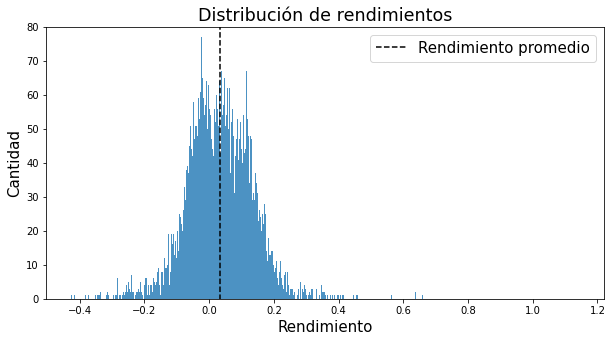

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(rendimientos['valor'],bins=1000,alpha=0.8)
plt.vlines(x=rendimientos['valor'].mean(),ymin=rendimientos['valor'].min(),ymax=80,linestyles='dashed',color='black',label="Rendimiento promedio")
plt.ylim([0,80])
plt.legend(loc=0,fontsize=15)
plt.ylabel("Cantidad",fontsize=15)
plt.xlabel("Rendimiento",fontsize=15)
plt.title("Distribución de rendimientos",fontsize=17.5)
plt.show()

This graph shows that the yields has a normal distribution, which is ok because all financial assets has normal distributed returns.

## Evaluation

In [ ]:
table = PrettyTable()
table.title = 'Variación de los rendimientos según el tipo de precio'
table.field_names = ['Tipo de precio','Coeficiente de variación']
for typ in rendimientos['dato'].unique():
    variable = rendimientos[rendimientos['dato'] == typ]['valor']
    variable = round(variable.std() / abs(variable.mean()),4)
    table.add_row([typ,variable])
table.sortby = 'Coeficiente de variación'
table.reverse_sort = True
print(table)

+--------------------------------------------------------+
| Variación de los rendimientos según el tipo de precio  |
+---------------------+----------------------------------+
|    Tipo de precio   |     Coeficiente de variación     |
+---------------------+----------------------------------+
|      Adj Close      |              2.7177              |
|        Close        |              2.8945              |
|         High        |              3.1195              |
|         Open        |              3.2162              |
|         Low         |              3.463               |
+---------------------+----------------------------------+


This table shows us that the type of price with lowest variation coefficient is the adjusted close price, which make sense because it consider stock splits and dividend payments. Therefore, it should be the best one to be considered for the investment strategy.

In [ ]:
rendimientosAC = rendimientos[rendimientos['dato'] == 'Adj Close']
variables = ['transformacion','segmentacion','min_max']

def Table_Presentation(columna='transformacion'):
    
    table = PrettyTable()
    table.field_names = [f'Tipo de {columna}','Rendimiento promedio','Coeficiente de variación']
    for typ in rendimientosAC[columna].unique():
        variable = rendimientosAC[rendimientosAC[columna] == typ]['valor']
        esperanza = round(variable.mean(),4)
        coefVar = round(variable.std() / abs(variable.mean()),2)
        table.add_row([typ,esperanza,coefVar])
    table.sortby = 'Rendimiento promedio'
    table.reversesort = True
    print(table)

for var in variables:
    Table_Presentation(columna=var)

+------------------------+----------------------+--------------------------+
| Tipo de transformacion | Rendimiento promedio | Coeficiente de variación |
+------------------------+----------------------+--------------------------+
|     sortino_ratio      |        0.0534        |           2.98           |
|        retorno         |        0.0439        |           2.35           |
|         riesgo         |        0.0419        |           2.8            |
|   information_ratio    |        0.0412        |           2.57           |
|      calmar_ratio      |        0.0406        |           2.56           |
|         sesgo          |        0.0387        |           2.42           |
|      burke_ratio       |        0.036         |           2.64           |
|        curtosis        |        0.0326        |           2.86           |
|      sharpe_ratio      |        0.0319        |           2.87           |
+------------------------+----------------------+--------------------------+

In this tables we can see that the type of segmentation and the type of sorting tables present the same pattern in which the category with the highest average yield has the lowest variation coefficient (equiprobable and descending respectively). This is not the case in the type of transformation table in which the second category (returns) with the highest average yield present the lowest variation coefficient.

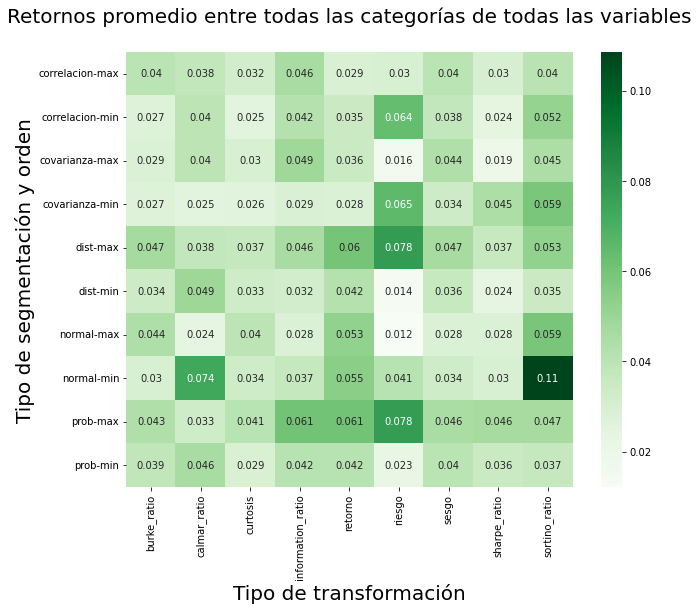

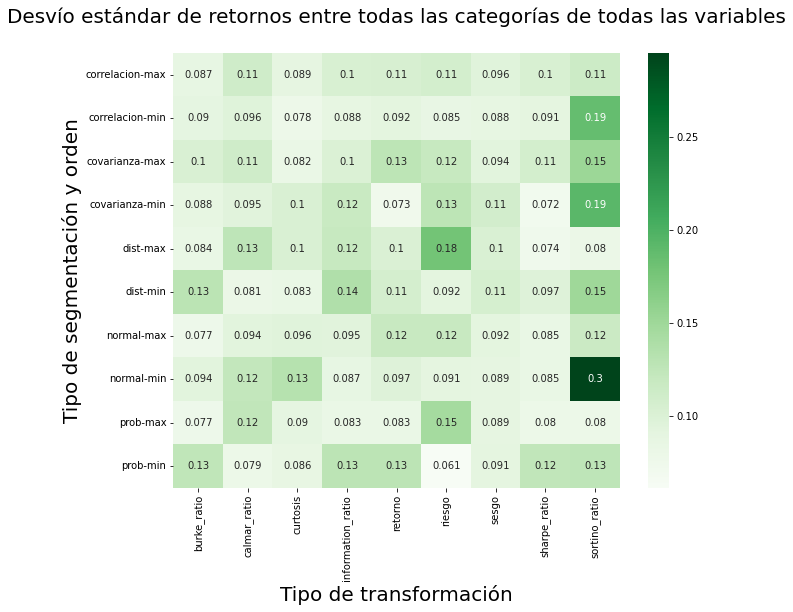

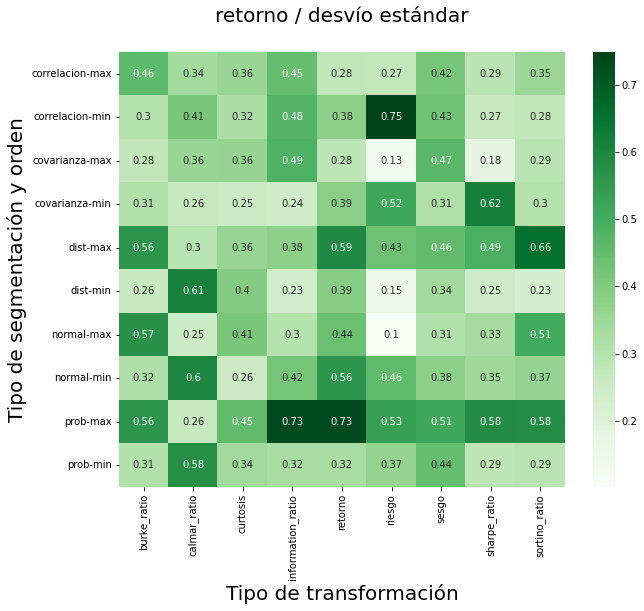

In [ ]:
pivot = pd.pivot_table(data=rendimientosAC,values='valor',columns=variables[0],index=[variables[1],variables[2]],aggfunc='mean')
plt.figure(figsize=(10,8))
sns.heatmap(pivot, cmap='Greens', annot=True)
plt.xlabel('Tipo de transformación',fontsize=20)
plt.ylabel('Tipo de segmentación y orden',fontsize=20)
plt.title("Retornos promedio entre todas las categorías de todas las variables",fontsize=20,pad=30)
plt.show()

pivot = pd.pivot_table(data=rendimientosAC,values='valor',columns=variables[0],index=[variables[1],variables[2]],aggfunc='std')
plt.figure(figsize=(10,8))
sns.heatmap(pivot, cmap='Greens', annot=True)
plt.xlabel('Tipo de transformación',fontsize=20)
plt.ylabel('Tipo de segmentación y orden',fontsize=20)
plt.title("Desvío estándar de retornos entre todas las categorías de todas las variables",fontsize=20,pad=30)
plt.show()

pivot = pd.pivot_table(data=rendimientosAC,values='valor',columns=variables[0],index=[variables[1],variables[2]],aggfunc='mean') / pd.pivot_table(data=rendimientosAC,values='valor',columns=variables[0],index=[variables[1],variables[2]],aggfunc='std')
plt.figure(figsize=(10,8))
sns.heatmap(pivot, cmap='Greens', annot=True)
plt.xlabel('Tipo de transformación',fontsize=20)
plt.ylabel('Tipo de segmentación y orden',fontsize=20)
plt.title("retorno / desvío estándar",fontsize=20,pad=30)
plt.show()

Regarding the first graph we can see that Return, Risk and Sortino Ratio transformation and Normal and Equiprobable types of segmentation present the highests returns.

Regarding the second graph we can see that notoriously Sortino Ratio transformation has the highest standard deviation among other combinations of variables.

Finally, regarding the third graph, which is a sort of Sharpe Ratio dividing the returns by the standard deviation of each combination, we can appreciate that the combination of Equiprobable segmentation, the Descending sorting and the Return transformation gives the best return-risk tradeoff for an investment strategy.